# Data from https://www.kaggle.com/c/bike-sharing-demand

You are provided hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.

**Data Fields**
- datetime - hourly date + timestamp  
- season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
- holiday - whether the day is considered a holiday
- workingday - whether the day is neither a weekend nor holiday
- weather
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy 
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp - temperature in Celsius
- atemp - 'feels like' temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- **count** (it's our target) - number of total rentals

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sb

## Read the dataset

In [2]:
dataset = pd.read_csv('bike_sharing_demand.csv')

In [3]:
dataset.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


What are the features type?

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.6+ KB


In [5]:
dataTypes = pd.DataFrame(dataset.dtypes.value_counts()).reset_index().rename(columns={'index':'Type',0:'Count'})

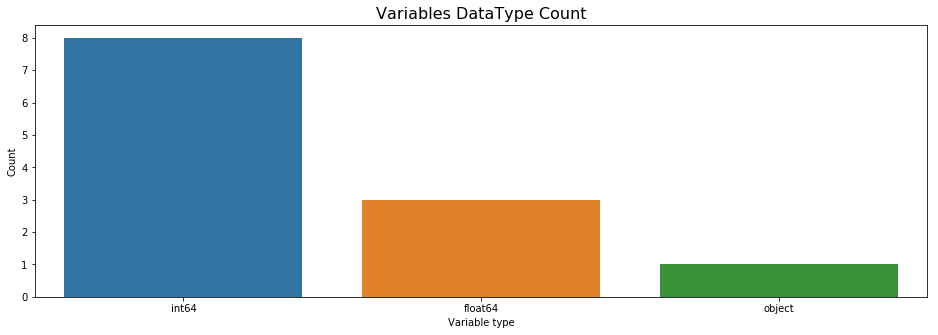

In [6]:
figure, axis = plt.subplots(figsize=(16,5))
sb.barplot(data=dataTypes,x='Type',y='Count',ax=axis)
axis.set(xlabel='Variable type', ylabel='Count')
axis.set_title('Variables DataType Count', fontsize=16)
plt.show()

Need to change datetime to datetime type 

In [7]:
dataset.datetime = dataset.datetime.apply(pd.to_datetime)

Let's create some new features: month and hour

In [8]:
dataset['month'] = dataset.datetime.apply(lambda x : x.month)
dataset['hour'] = dataset.datetime.apply(lambda x : x.hour)
dataset['weekday'] = dataset.datetime.apply(lambda x: x.weekday())
seasons_order = ['Spring', 'Summer', 'Autumn', 'Winter']
dataset['season'] = dataset.season.map(dict(zip(range(1,5),seasons_order)))

In [9]:
dataset.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,hour,weekday
0,2011-01-01 00:00:00,Spring,0,0,1,9.84,14.395,81,0.0,3,13,16,1,0,5
1,2011-01-01 01:00:00,Spring,0,0,1,9.02,13.635,80,0.0,8,32,40,1,1,5
2,2011-01-01 02:00:00,Spring,0,0,1,9.02,13.635,80,0.0,5,27,32,1,2,5
3,2011-01-01 03:00:00,Spring,0,0,1,9.84,14.395,75,0.0,3,10,13,1,3,5
4,2011-01-01 04:00:00,Spring,0,0,1,9.84,14.395,75,0.0,0,1,1,1,4,5


## Columns type

In [10]:
binary_data_columns = ['holiday', 'workingday']
numeric_data_columns = ['temp', 'atemp', 'humidity', 'windspeed', 'hour']
categorial_data_columns = ['weather', 'weekday', 'month', 'season'] 

In [11]:
columns_type = pd.DataFrame({'Column name': dataset.columns})
column_names = ['Binary','Numeric','Categorial']
for name, data in zip(column_names, [binary_data_columns, numeric_data_columns, categorial_data_columns]):
    columns_type[name] = columns_type['Column name'].apply(lambda x: x in data)

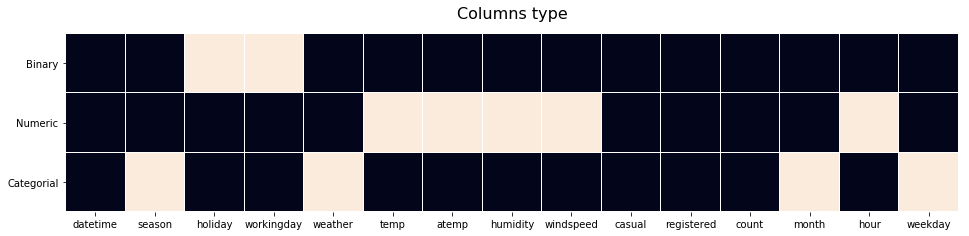

In [12]:
figure, axis = plt.subplots(figsize=(16,6))
axis.set_title('Columns type', fontsize=16, y=1.05)
sb.heatmap(data=columns_type[column_names].T, linewidths=0.1, linecolor='white',
           xticklabels=columns_type['Column name'],
           yticklabels=column_names, ax=axis, cbar=False, square=True)
plt.yticks(rotation=0) 
plt.show()

## Make some visualization

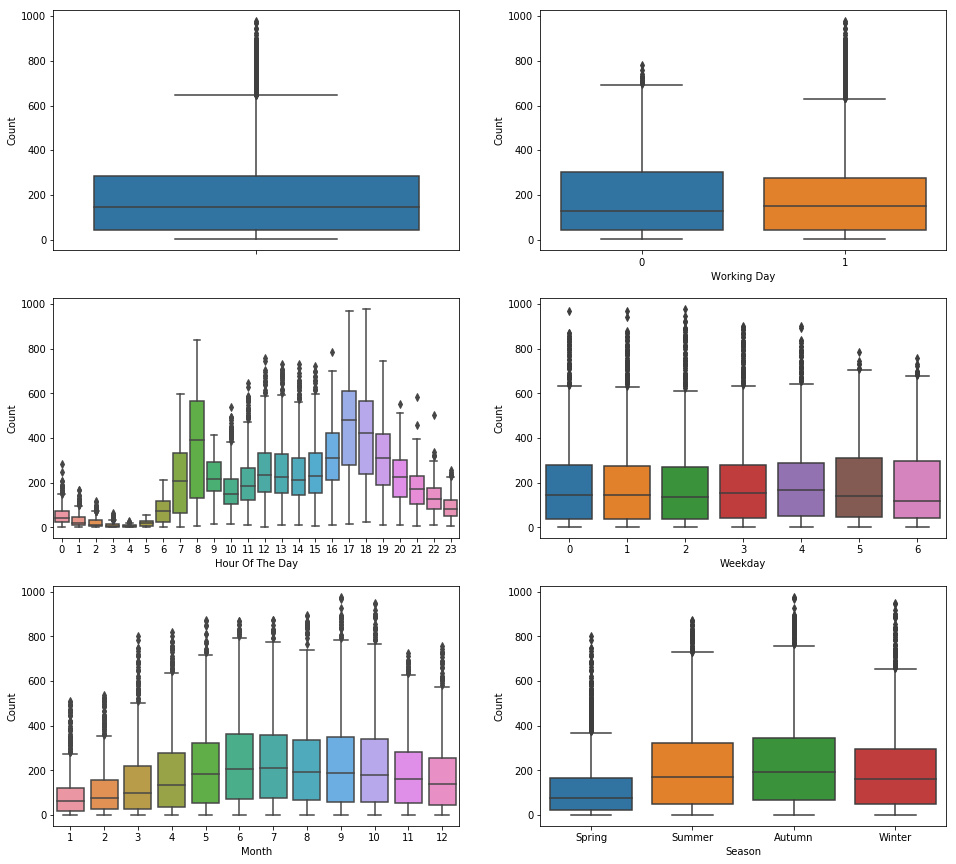

In [13]:
figure, axis = plt.subplots(nrows=3,ncols=2, figsize=(16,15))
columns = [None, 'workingday','hour','weekday','month','season']
xlabels = ['','Working Day','Hour Of The Day','Weekday','Month','Season']
for column, xlabel, ax in zip(columns, xlabels, axis.flatten()):
    sb.boxplot(data=dataset,y='count',x=column,orient='v',ax=ax)
    ax.set(xlabel=xlabel, ylabel='Count')

## Ploting correlation matrix

In [14]:
def plot_correlation(dataframe, columns):
    colormap = plt.cm.RdBu
    correlation_matrix = dataframe[columns].corr()
    mask = np.array(correlation_matrix)
    mask[np.tril_indices_from(mask)] = False
    figure,axis = plt.subplots(figsize=(10,10))
    sb.heatmap(correlation_matrix, mask=mask,vmax=.8, annot=True, square=True, ax=axis,
               cmap=colormap, cbar=False,  )
    plt.title('Correlation matrix', y=1.05, fontsize=16)
    plt.yticks(rotation=0)

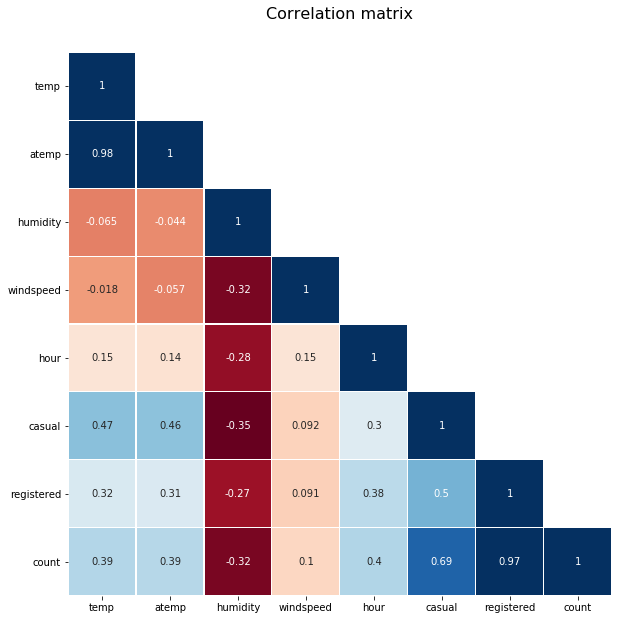

In [15]:
plot_correlation(dataset, numeric_data_columns + ['casual','registered','count'])

We can see that **temp** and **atemp** are highly correlated between each other. We should use only one of them or need to include some regularization to our models. Besides, **registered** and **casual** are highly correlated with **count**. But it's not strange, cause sum of those features is actualy out **count**. We should exclude those features from our training dataset.

## More beautiful charts

In [16]:
weekday_order = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]
month_order = ["January","February","March","April","May","June","July",
               "August","September","October","November","December"]

In [17]:
dataset.month = dataset.month.map(dict(zip(range(1,13), month_order)))
dataset.weekday = dataset.weekday.map(dict(zip(range(7), weekday_order)))

In [18]:
dataset.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,hour,weekday
0,2011-01-01 00:00:00,Spring,0,0,1,9.84,14.395,81,0.0,3,13,16,January,0,Friday
1,2011-01-01 01:00:00,Spring,0,0,1,9.02,13.635,80,0.0,8,32,40,January,1,Friday
2,2011-01-01 02:00:00,Spring,0,0,1,9.02,13.635,80,0.0,5,27,32,January,2,Friday
3,2011-01-01 03:00:00,Spring,0,0,1,9.84,14.395,75,0.0,3,10,13,January,3,Friday
4,2011-01-01 04:00:00,Spring,0,0,1,9.84,14.395,75,0.0,0,1,1,January,4,Friday


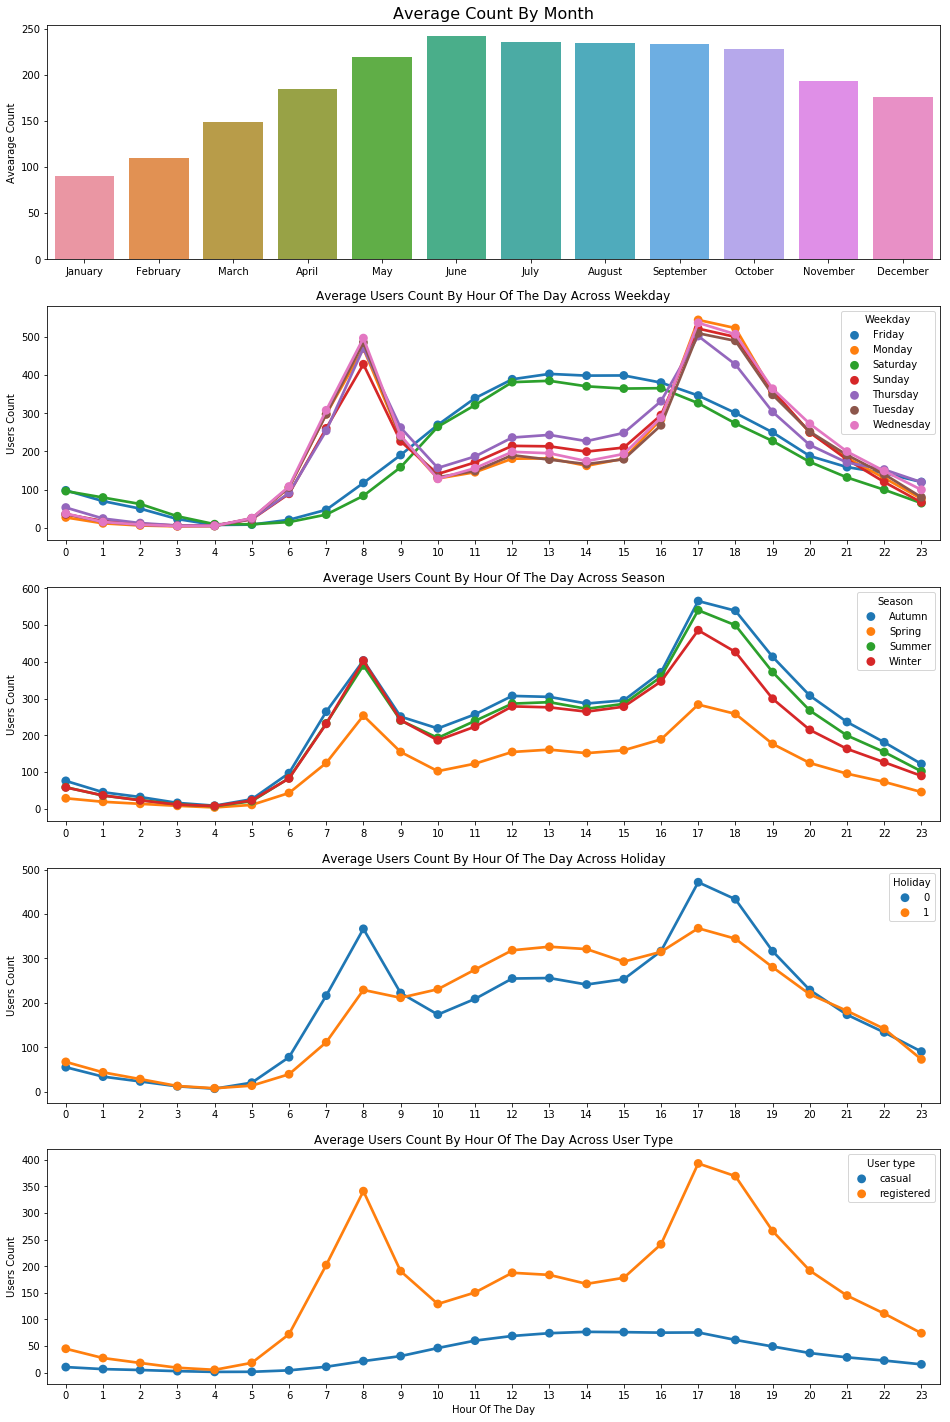

In [19]:
figure, axis = plt.subplots(nrows=5, figsize=(16,25))

count_per_month = pd.DataFrame(dataset.groupby("month")["count"].mean()).reset_index()
sb.barplot(data=count_per_month,x="month",y="count", ax=axis[0], order=month_order)
axis[0].set(xlabel='', ylabel='Avearage Count')
axis[0].set_title("Average Count By Month", fontsize=16)

groupby = [["hour","weekday"], ["hour","season"], ["hour","holiday"]]
titles =  ['Weekday','Season', 'Holiday']
for group, title, ax in zip(groupby, titles, axis[1:]):
    dataframe = pd.DataFrame(dataset.groupby(group)["count"].mean()).reset_index()
    sb.pointplot(data=dataframe, ax=ax, join=True,
                 x=dataframe["hour"],
                 y=dataframe["count"],
                 hue=dataframe[group[-1]])
    ax.set(xlabel='',
           ylabel='Users Count',
           title=f"Average Users Count By Hour Of The Day Across {title}", label='big')
    legend_handles = ax.get_legend_handles_labels()[0]
    ax.legend(title=title)

#Ploting count across user type
hour_across_user_type = pd.melt(dataset[["hour","casual","registered"]],
                                id_vars=['hour'],
                                value_vars=['casual', 'registered'])
count_per_hour_user_type = pd.DataFrame(hour_across_user_type.groupby(["hour","variable"],sort=True)["value"] \
                                        .mean()).reset_index()
sb.pointplot(data=count_per_hour_user_type,
             x=count_per_hour_user_type["hour"],
             y=count_per_hour_user_type["value"],
             hue=count_per_hour_user_type["variable"],
             hue_order=["casual","registered"], join=True, ax=axis[4])
axis[4].set(xlabel='Hour Of The Day',
            ylabel='Users Count',
            title="Average Users Count By Hour Of The Day Across User Type", label='big')
axis[4].legend(title='User type')
plt.show()

**Count** and **numerical variables**

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


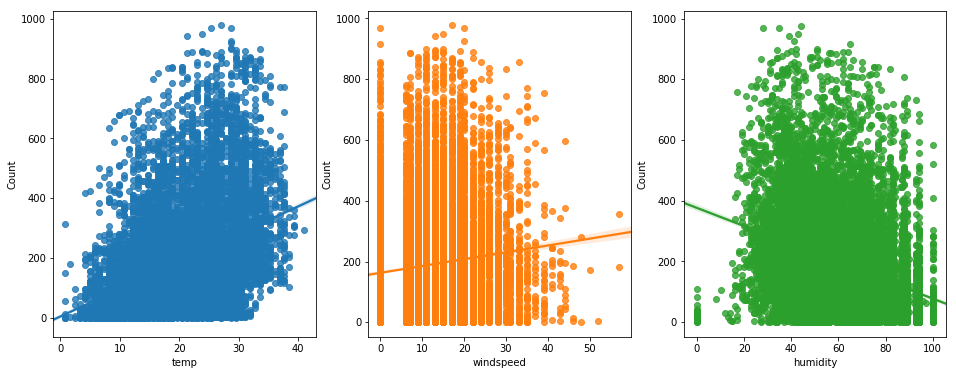

In [20]:
figure, axis = plt.subplots(ncols=3, figsize=(16,6))
for variable, ax in zip(['temp', 'windspeed', 'humidity'], axis):
    sb.regplot(x=dataset[variable], y=dataset['count'], data=dataset, ax=ax)
    ax.set(xlabel=variable, ylabel='Count')

## Creating validation and train data

In [21]:
train = dataset.iloc[:-1000, :]
validation = dataset.iloc[-1000:, :]

## Removing outliers

In [22]:
def get_outliers_indexes(dataframe, column_name):
    "IQR (interquartile range) method of outlier detection developed by John Tukey"
    quartile_1, quartile_3 = np.percentile(dataframe[column_name].dropna(), [25, 75])
    interquartile_range = quartile_3 - quartile_1
    lower_bound = quartile_1 - (interquartile_range * 1.5)
    upper_bound = quartile_3 + (interquartile_range * 1.5)
    return dataframe[(dataframe[column_name] > upper_bound) |
                     (dataframe[column_name] < lower_bound)].index

In [23]:
outliers_indexes = get_outliers_indexes(train, 'count')

In [24]:
trainWO = train.drop(index=outliers_indexes, axis=0)

Check results of outliers removing

In [25]:
#implementing functions for nice output
def wrapper(function):
    def wrapped():
        return '-'*55+'\n'+f'{function()}'+'\n'+'-'*55
    return wrapped

@wrapper
def get_outlier_removing_results():
    line1 = f'Completely removed {train.shape[0]-trainWO.shape[0]} samples'
    line2 = f'Number of samples before removing the outliers: {train.shape[0]}'
    line3 = f'Number of samples after removing the outliers: {trainWO.shape[0]}'
    return '\n'.join([line1,line2,line3])

In [26]:
print('Outliers removing...')
print(get_outlier_removing_results())

Outliers removing...
-------------------------------------------------------
Completely removed 296 samples
Number of samples before removing the outliers: 9886
Number of samples after removing the outliers: 9590
-------------------------------------------------------


Training and validation data

In [27]:
train_data = trainWO.drop(['datetime', 'count', 'casual', 'registered'], axis = 1)
train_labels = trainWO['count'].values

validation_data = validation.drop(['datetime', 'count', 'casual', 'registered'], axis = 1)
validation_labels = validation['count'].values

In [28]:
train_data.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,month,hour,weekday
0,Spring,0,0,1,9.84,14.395,81,0.0,January,0,Friday
1,Spring,0,0,1,9.02,13.635,80,0.0,January,1,Friday
2,Spring,0,0,1,9.02,13.635,80,0.0,January,2,Friday
3,Spring,0,0,1,9.84,14.395,75,0.0,January,3,Friday
4,Spring,0,0,1,9.84,14.395,75,0.0,January,4,Friday


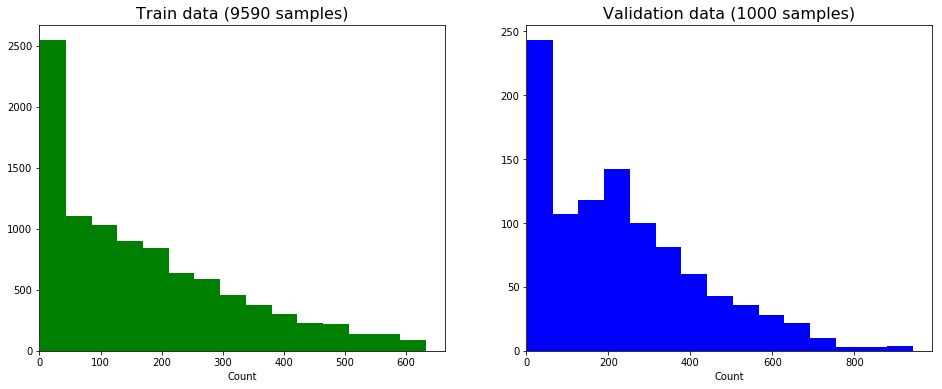

In [29]:
figure, axis = plt.subplots(nrows=1,ncols=2,figsize = (16, 6))
for data, title, color, ax in zip([trainWO,validation],['Train data','Validation data'],['green','blue'],axis):
    sb.distplot(data['count'], ax=ax, kde=False, bins=15,
                hist_kws={"histtype": "bar", "alpha": 1, "color": color})
    ax.set(xlabel='Count')
    ax.set_title(title + f' ({data.shape[0]} samples)', fontsize=16)
    ax.set_xlim(xmin=0)

In [31]:
from sklearn.linear_model import SGDRegressor, LinearRegression, Ridge, Lasso
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import mean_absolute_error as mae
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer, StandardScaler, LabelEncoder, OneHotEncoder

import warnings
warnings.filterwarnings(action='ignore')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Label encoding categorial features

In [32]:
for data in (train_data, validation_data):
    for column in categorial_data_columns:
        le = LabelEncoder()
        le.fit(data[column])
        data[column] = le.transform(data[column])

In [33]:
train_data.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,month,hour,weekday
0,1,0,0,0,9.84,14.395,81,0.0,4,0,0
1,1,0,0,0,9.02,13.635,80,0.0,4,1,0
2,1,0,0,0,9.02,13.635,80,0.0,4,2,0
3,1,0,0,0,9.84,14.395,75,0.0,4,3,0
4,1,0,0,0,9.84,14.395,75,0.0,4,4,0


## Modeling

In [34]:
columns_type.set_index('Column name',inplace=True)
columns_type = columns_type.drop(index=['datetime', 'count', 'casual', 'registered'], axis = 0)
columns_type

,Binary,Numeric,Categorial
Column name,,,
season,False,False,True
holiday,True,False,False
workingday,True,False,False
weather,False,False,True
temp,False,True,False
atemp,False,True,False
humidity,False,True,False
windspeed,False,True,False
month,False,False,True


## LinearRegression

Let's begin with simple linear model

In [35]:
linear_regressor = LinearRegression()
estimator_linear_regressor = Pipeline(steps = [
    ('feature_processing', FeatureUnion(transformer_list = [
        ('binary_variables_processing', FunctionTransformer(lambda data: data[:, columns_type['Binary']])),
        ('numeric_variables_processing', Pipeline(steps = [
            ('selecting', FunctionTransformer(lambda data: data[:, columns_type['Numeric']])),
            ('scaling', StandardScaler(with_mean = 0, with_std = 1))            
        ])),
        ('categorical_variables_processing', Pipeline(steps = [
            ('selecting', FunctionTransformer(lambda data: data[:, columns_type['Categorial']])),
            ('hot_encoding', OneHotEncoder(handle_unknown = 'ignore'))            
        ])),
    ])),
    ('model_fitting', linear_regressor)])

In [36]:
estimator_linear_regressor.fit(train_data, train_labels)
mae_estimator_linear_regressor = mae(validation_labels, estimator_linear_regressor.predict(validation_data))
print(mae_estimator_linear_regressor)

154.41181386170126


In [37]:
models = pd.DataFrame({
    'Model': ['Linear Regression'],
    'Score': [mae_estimator_linear_regressor]})

## Ridge

In [38]:
ridge_estimator = Ridge()

In [39]:
estimator_ridge_regressor = Pipeline(steps = [
    ('feature_processing', FeatureUnion(transformer_list = [
        ('binary_variables_processing', FunctionTransformer(lambda data: data[:, columns_type['Binary']])),
        ('numeric_variables_processing', Pipeline(steps = [
            ('selecting', FunctionTransformer(lambda data: data[:, columns_type['Numeric']])),
            ('scaling', StandardScaler(with_mean = 0, with_std = 1))            
        ])),
        ('categorical_variables_processing', Pipeline(steps = [
            ('selecting', FunctionTransformer(lambda data: data[:, columns_type['Categorial']])),
            ('hot_encoding', OneHotEncoder(handle_unknown = 'ignore'))            
        ])),
    ])),
    ('model_fitting', ridge_estimator)])

In [49]:
estimator_ridge_regressor.fit(train_data, train_labels)

Pipeline(memory=None,
     steps=[('feature_processing', FeatureUnion(n_jobs=1,
       transformer_list=[('binary_variables_processing', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x000001DED64F8510>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y='deprecated',
         ...it_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

In [50]:
mae_grid_ridge_cv = mae(validation_labels, estimator_ridge_regressor.predict(validation_data))
print(mae_grid_ridge_cv)

154.093071710026


In [51]:
models = models.append({'Model': 'Ridge Regression','Score':mae_grid_ridge_cv}, ignore_index=True)

## Lasso

In [52]:
lasso_estimator = Lasso()

In [53]:
estimator_lasso_regressor = Pipeline(steps = [
    ('feature_processing', FeatureUnion(transformer_list = [
        ('binary_variables_processing', FunctionTransformer(lambda data: data[:, columns_type['Binary']])),
        ('numeric_variables_processing', Pipeline(steps = [
            ('selecting', FunctionTransformer(lambda data: data[:, columns_type['Numeric']])),
            ('scaling', StandardScaler(with_mean = 0, with_std = 1))            
        ])),
        ('categorical_variables_processing', Pipeline(steps = [
            ('selecting', FunctionTransformer(lambda data: data[:, columns_type['Categorial']])),
            ('hot_encoding', OneHotEncoder(handle_unknown = 'ignore'))            
        ])),
    ])),
    ('model_fitting', lasso_estimator)])

In [54]:
lasso_params = { 'max_iter':[3000],'alpha':[0.001,0.01,0.05, 0.1, 1, 2, 3, 4, 10, 30,100] }
grid_lasso_cv = GridSearchCV(lasso_estimator, lasso_params, scoring = 'mean_absolute_error', cv = 4)

In [55]:
grid_lasso_cv.fit(train_data, train_labels)

GridSearchCV(cv=4, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_iter': [3000], 'alpha': [0.001, 0.01, 0.05, 0.1, 1, 2, 3, 4, 10, 30, 100]},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_absolute_error',
       verbose=0)

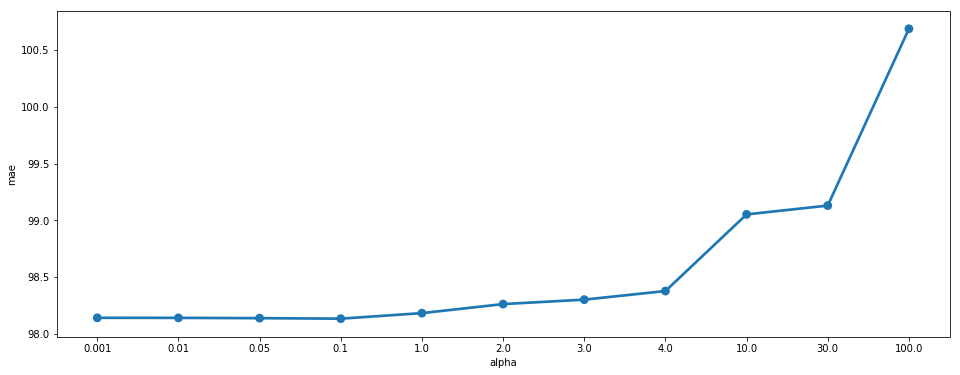

In [56]:
df_grid_lasso_cv = pd.DataFrame(grid_lasso_cv.grid_scores_)
df_grid_lasso_cv["alpha"] = df_grid_lasso_cv["parameters"].apply(lambda x:x["alpha"])
df_grid_lasso_cv["mae"] = df_grid_lasso_cv["mean_validation_score"].apply(lambda x:-x)

figure = plt.figure(figsize=(16,6))
sb.pointplot(data=df_grid_lasso_cv,x="alpha",y="mae")
plt.show()

In [57]:
mae_grid_lasso_cv = mae(validation_labels, grid_lasso_cv.predict(validation_data))
print(mae_grid_lasso_cv)

150.94539334417797


In [58]:
models = models.append({'Model': 'Lasso Regression','Score':mae_grid_lasso_cv}, ignore_index=True)

## Ensemble Models - Random Forest

In [59]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(random_state = 0, max_depth = 20, n_estimators = 100)

In [60]:
estimator_forest_regressor = Pipeline(steps = [
    ('feature_processing', FeatureUnion(transformer_list = [
        ('binary_variables_processing', FunctionTransformer(lambda data: data[:, columns_type['Binary']])),
        ('numeric_variables_processing', Pipeline(steps = [
            ('selecting', FunctionTransformer(lambda data: data[:, columns_type['Numeric']])),
            ('scaling', StandardScaler(with_mean = 0, with_std = 1))            
        ])),
        ('categorical_variables_processing', Pipeline(steps = [
            ('selecting', FunctionTransformer(lambda data: data[:, columns_type['Categorial']])),
            ('hot_encoding', OneHotEncoder(handle_unknown = 'ignore'))            
        ])),
    ])),
    ('model_fitting', regressor)])

In [61]:
estimator_forest_regressor.fit(train_data, train_labels)

Pipeline(memory=None,
     steps=[('feature_processing', FeatureUnion(n_jobs=1,
       transformer_list=[('binary_variables_processing', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x000001DED8233D08>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y='deprecated',
         ...estimators=100, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False))])

In [62]:
mae_random_forest = mae(validation_labels, estimator_forest_regressor.predict(validation_data))
print(mae_random_forest)

90.25593867892317


In [63]:
models = models.append({'Model': 'Random Forest','Score':mae_random_forest}, ignore_index=True)

## Ensemble Model - Gradient Boost

In [64]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(n_estimators=4000,alpha=0.01)

In [65]:
estimator_gbm = Pipeline(steps = [
    ('feature_processing', FeatureUnion(transformer_list = [
        ('binary_variables_processing', FunctionTransformer(lambda data: data[:, columns_type['Binary']])),
        ('numeric_variables_processing', Pipeline(steps = [
            ('selecting', FunctionTransformer(lambda data: data[:, columns_type['Numeric']])),
            ('scaling', StandardScaler(with_mean = 0, with_std = 1))            
        ])),
        ('categorical_variables_processing', Pipeline(steps = [
            ('selecting', FunctionTransformer(lambda data: data[:, columns_type['Categorial']])),
            ('hot_encoding', OneHotEncoder(handle_unknown = 'ignore'))            
        ])),
    ])),
    ('model_fitting', gbm)])

In [66]:
estimator_gbm.fit(train_data, train_labels)

Pipeline(memory=None,
     steps=[('feature_processing', FeatureUnion(n_jobs=1,
       transformer_list=[('binary_variables_processing', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x000001DED8233F28>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y='deprecated',
         ...=4000, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False))])

In [67]:
mae_gbm = mae(validation_labels, estimator_gbm.predict(validation_data))
print(mae_gbm)

94.85639826676055


In [68]:
models = models.append({'Model': 'Gradient Boost','Score':mae_gbm}, ignore_index=True)

In [69]:
models.sort_values(by='Score', ascending=True, inplace=True)

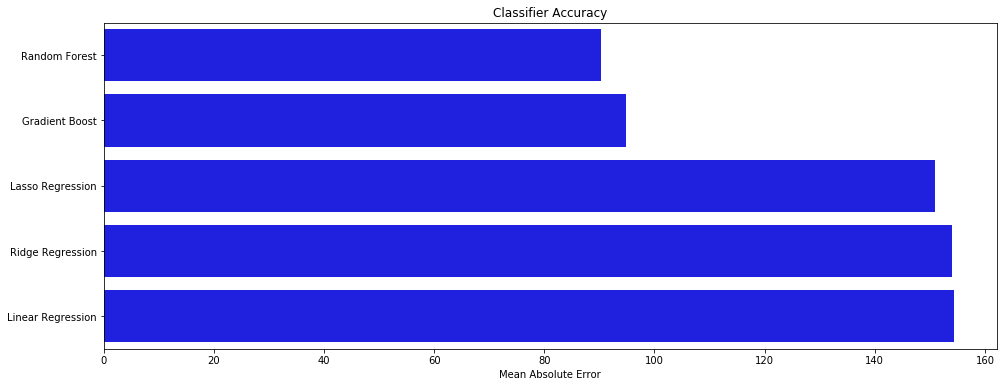

In [70]:
figure, axis = plt.subplots(figsize=(16,6))
sb.barplot(x='Score', y='Model', data=models, color='b', ax=axis)
axis.set(xlabel='Mean Absolute Error', ylabel='', title='Classifier Accuracy', label='big')
plt.show()